In [ ]:
import numpy as np
import torch

from dispNN import dispNN
from densNN import densNN, fourier_map
from loss import energy_vol
from mesh import generate_points
from utils import plotTO

def set_seed(seed=1234):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)

set_seed()

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [ ]:
# -------------------- Geometry & loading --------------------
geom = {"xmin": 0.0, "ymin": 0.0, "zmin": 0.0, "xmax": 2.0, "ymax": 1.0, "zmax": 0.25}
force = -0.1
load_frac = 0.05 * (geom["xmax"] - geom["xmin"])
load_area = load_frac*(geom["zmax"] - geom["zmin"])
domain_area = (geom["xmax"] - geom["xmin"]) * (geom["ymax"] - geom["ymin"])
domain_volume = (geom["xmax"] - geom["xmin"]) * (geom["ymax"] - geom["ymin"]) * (geom["zmax"] - geom["zmin"])
#  Material (SIMP)
mat = {"nu": 0.3, "E0": 1.0, "Emin": 1e-9, "penal": 3, "vol_frac": 0.25,}
grid = {"nx": 120, "ny": 60, "nz": 15}
ff_cfg = {"n_feat": 150, "std": 1.0}
B = torch.as_tensor(np.random.normal(0, ff_cfg["std"], (3, ff_cfg["n_feat"])),
    device=DEVICE, dtype=torch.float32)
# -------------------- Network architecture --------------------
net_cfg = {"disp": {"layers": 4, "width": 60, "in_dim": 3},
        "dens": {"layers": 3, "width": 60, "in_dim": 2 * ff_cfg["n_feat"]},}

# -------------------- Training setup --------------------
train_cfg = {
    "lr_u": 1e-3,
    "lr_rho": 1e-2,
    "epochs": 250,
    "pre_disp": 50,
    "disp_steps": 1,
    "lam": 50,
    "tol": 0.05,
}
batch_size = 5000

In [ ]:
# -------------------- Networks --------------------
u_model = dispNN(net_cfg["disp"]["in_dim"],
               net_cfg["disp"]["layers"],
               net_cfg["disp"]["width"]).to(DEVICE)

v_model = dispNN(net_cfg["disp"]["in_dim"],
               net_cfg["disp"]["layers"],
               net_cfg["disp"]["width"]).to(DEVICE)

w_model = dispNN(net_cfg["disp"]["in_dim"],
               net_cfg["disp"]["layers"],
               net_cfg["disp"]["width"]).to(DEVICE)

rho_model = densNN(net_cfg["dens"]["in_dim"],
                 net_cfg["dens"]["layers"],
                 net_cfg["dens"]["width"]).to(DEVICE)

# -------------------- Optimizers --------------------
opt_disp = torch.optim.Adam(
    list(u_model.parameters()) + list(v_model.parameters()) + list(w_model.parameters()),
    lr=train_cfg["lr_u"],
    amsgrad=True,maximize = True)
opt_dens = torch.optim.Adam(
    rho_model.parameters(),
    lr=train_cfg["lr_rho"],
    amsgrad=True)
loss_mse = torch.nn.MSELoss()

In [ ]:
# -------------------- Collocation & boundary points --------------------
x_all, y_all, z_all, Xg, Yg, Zg, fixed_mask, load_pt_mask = generate_points(geom["xmin"], 
            geom["ymin"], geom["zmin"], geom["xmax"], geom["ymax"], geom["zmax"] , grid["nx"], grid["ny"], grid["nz"], device=DEVICE)

# Exclude load point from collocation
free_mask = ~load_pt_mask

Xc = x_all[free_mask].view(-1, 1)
Yc = y_all[free_mask].view(-1, 1)
Zc = z_all[free_mask].view(-1, 1)

X_fix = x_all[fixed_mask].view(-1, 1)
Y_fix = y_all[fixed_mask].view(-1, 1)
Z_fix = z_all[fixed_mask].view(-1, 1)

X_load = x_all[load_pt_mask].view(-1, 1)
Y_load = y_all[load_pt_mask].view(-1, 1)
Z_load = z_all[load_pt_mask].view(-1, 1)

# -------------------- Boundary ansatz --------------------
u_bc = 0.0                     # prescribed displacement
# bc_shape = X                   # vanishing function at fixed boundary

def eval_density(xc, yc, zc, rho_model, proj_mat):
    features = fourier_map(xc, yc, zc, proj_mat)
    return rho_model(features)

In [ ]:
coords = torch.cat([Xc, Yc, Zc], dim=1).detach().to(DEVICE)
rho_field = eval_density(Xc, Yc, Zc, rho_model, B)
J0 = None  # Initialize J0 as None
perm = torch.randperm(coords.size(0), device=DEVICE)

In [ ]:
for epoch in range(1,train_cfg["epochs"] + 1):
    total_int_energy = 0.0
    total_ext_energy = 0.0
    total_total_energy = 0.0
    print(epoch)
    opt_dens.zero_grad()
    for i in range(0, coords.size(0), batch_size):
        batch = coords[perm[i:i+batch_size]]
        batch.requires_grad_(True)
        batch_xi = batch[:,0:1]
        batch_yi = batch[:,1:2]
        batch_zi = batch[:,2:3] 
        rho_inp = rho_field[perm[i:i+batch_size]]
        opt_disp.zero_grad()
        int_energy = energy_vol(u_bc, batch_xi, batch_yi, batch_zi, u_model, v_model, 
                                w_model, rho_inp, mat["Emin"], mat["E0"], mat["penal"], mat["nu"], domain_volume)
        total_int_energy += int_energy.item()
        # External energy
        disp_load = u_bc + X_load * v_model(X_load,Y_load,Z_load)
        ext_energy = torch.sum(force * disp_load) * (load_area / X_load.shape[0])
        total_ext_energy = ext_energy.item()

        total_energy = (ext_energy - int_energy)
        total_total_energy += total_energy.item()
        # Backpropagate and optimize
        if epoch <= train_cfg["pre_disp"]:
            obj = total_energy
            obj.backward(retain_graph=True)
            opt_disp.step()
        else:
            opt_disp.param_groups[0]['lr'] = train_cfg["lr_u"]/10
            if J0 is None:
                J0 = total_energy.item() # Initialize J0 after initial epochs
            obj = total_energy / J0
            obj.backward(retain_graph=True)
            opt_disp.step()
            
    # Calculate volume fraction using accumulated rho
    vol_frac = torch.sum(rho_field) * (domain_volume / rho_field.shape[0]) / domain_volume
    vol_penalty = (1 - vol_frac / mat["vol_frac"]) ** 2
    # Adjust obj for volume constraint
    if epoch > train_cfg["pre_disp"]:
        obj = total_total_energy / J0 + 50 * vol_penalty
        obj.backward(retain_graph=True)
        opt_dens.step()
        rho_field = eval_density(Xc, Yc, Zc, rho_model, B)
    percent_gray = ((rho_field >= 0.15) & (rho_field <= 0.85)).float().mean().item() * 100
    # print(percent_gray)
    if percent_gray < 4:
        break

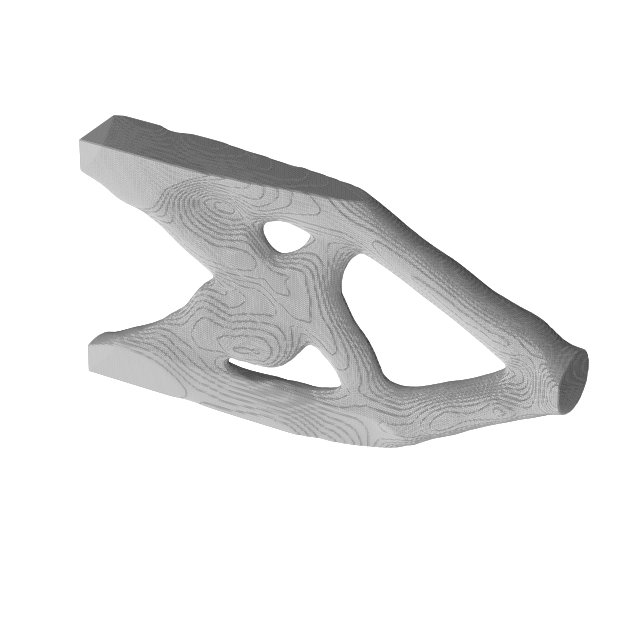

XDMF file 'epoch_224.xdmf' created successfully.


In [ ]:
plotTO(x_all, y_all, z_all, Xg, Yg, Zg, rho_model, B, epoch)